# Phishing Messages Detector

In [1]:
import os
import nltk
import tqdm
import joblib
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

from gensim.models.fasttext import FastText

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\blues\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\blues\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\blues\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\blues\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\blues\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\blues\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-d

True

In [2]:
df = pl.read_json('./datasets/dataset.json')

In [3]:
model_and_pre_processor = {"pre-processor": None, "model": None}

## Data Pre-processing

In [4]:
def _nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:          
        return None


def _nltk_pos_lemmatizer(lemmatizer, token, tag):
    if tag is None:
        return lemmatizer.lemmatize(token)
    else:        
        return lemmatizer.lemmatize(token, tag)


def text_pre_processing(txt, m=2):
    if txt is not None:
        lemmatizer = nltk.WordNetLemmatizer()
        stop_words = set(nltk.corpus.stopwords.words('english'))

        tokens = nltk.word_tokenize(txt)
        tokens = [w for w in tokens if w.isalpha()]
        tokens = [w for w in tokens if w not in stop_words]
        tokens = nltk.pos_tag(tokens)
        tokens = [(t[0], _nltk_pos_tagger(t[1])) for t in tokens]
        tokens = [_nltk_pos_lemmatizer(lemmatizer, w, t).lower() for w,t in tokens]
        tokens = [w for w in tokens if len(w) > m]
    else:
        tokens = []
    return tokens

In [5]:
dataset = [(text, label) for (text, label) in df.rows()]

In [6]:
corpus = [text for text, _ in dataset]
y = [label for _, label in dataset]

In [7]:
tokens_clean = joblib.Parallel(n_jobs=-1)(joblib.delayed(text_pre_processing)(text) for text in corpus)
tokens_merge = [' '.join(line) for line in tokens_clean]

### Bag of Words

In [10]:
X_train, X_test, y_train, y_test = train_test_split(tokens_merge, y, test_size=0.2, random_state=42)

In [11]:
pre_processor = "Bag of Words"
cv = CountVectorizer(ngram_range = (1, 2), max_features=512)
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()
model_and_pre_processor["pre-processor"] = cv

### Fast Text

In [8]:
pre_processor = "Fast text"
text_model = FastText(vector_size=512, window=7, min_count=3, workers=os.cpu_count(), seed=42)
text_model.build_vocab(tokens_clean)
model_and_pre_processor["pre-processor"] = text_model

In [9]:
def div_norm(x):
   norm_value = np.linalg.norm(x)
   if norm_value > 0:
       return x * ( 1.0 / norm_value)
   else:
       return x

def word_vector_to_sentence_vector(sentence:list, model):
    vectors = []
    # for all the tokens in the setence
    for token in sentence:
        if token in model:
            vectors.append(model[token])
    # add the EOS token
    if '\n' in model:
        vectors.append(model['\n'])
    # normalize all the vectors
    vectors = [div_norm(x) for x in vectors]
    return np.mean(vectors, axis=0)

In [10]:
X = np.array([word_vector_to_sentence_vector(sentence, text_model.wv) for sentence in tqdm.tqdm(tokens_clean)])

100%|██████████| 20301/20301 [01:06<00:00, 307.22it/s] 


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TF-IDF

In [23]:
X_train, X_test, y_train, y_test = train_test_split(tokens_merge, y, test_size=0.2, random_state=42)

In [24]:
pre_processor = "TF-IDF"
vectorizer = TfidfVectorizer(max_features=512)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()
model_and_pre_processor["pre-processor"] = vectorizer

## Train Model and Evaluate

Pre-Process used: Fast text
Classification Report for LR:

              precision    recall  f1-score   support

      Benign       0.63      1.00      0.77      2542
    Phishing       0.96      0.02      0.03      1519

    accuracy                           0.63      4061
   macro avg       0.79      0.51      0.40      4061
weighted avg       0.75      0.63      0.49      4061



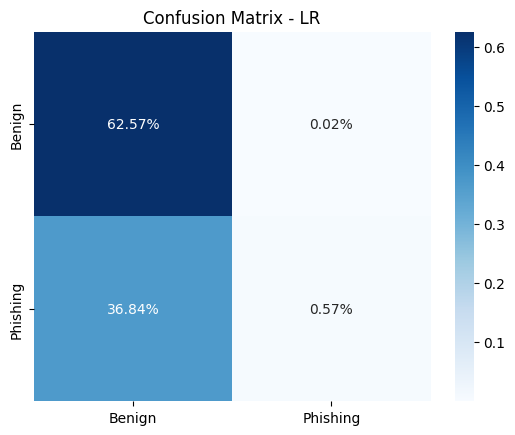

Classification Report for KNN:

              precision    recall  f1-score   support

      Benign       0.87      0.92      0.89      2542
    Phishing       0.85      0.78      0.81      1519

    accuracy                           0.87      4061
   macro avg       0.86      0.85      0.85      4061
weighted avg       0.86      0.87      0.86      4061



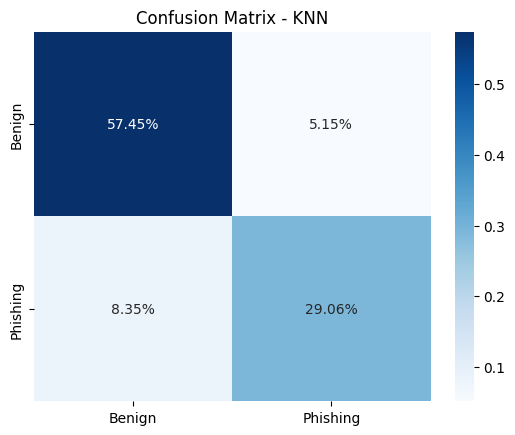

Classification Report for RFC:

              precision    recall  f1-score   support

      Benign       0.81      0.99      0.89      2542
    Phishing       0.98      0.61      0.75      1519

    accuracy                           0.85      4061
   macro avg       0.89      0.80      0.82      4061
weighted avg       0.87      0.85      0.84      4061



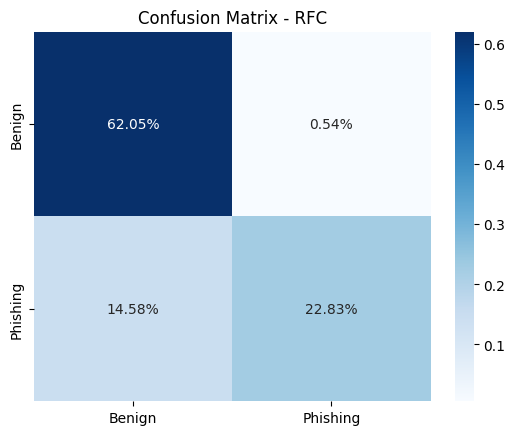

Classification Report for MLP:

              precision    recall  f1-score   support

      Benign       0.95      0.93      0.94      2542
    Phishing       0.89      0.92      0.91      1519

    accuracy                           0.93      4061
   macro avg       0.92      0.93      0.92      4061
weighted avg       0.93      0.93      0.93      4061



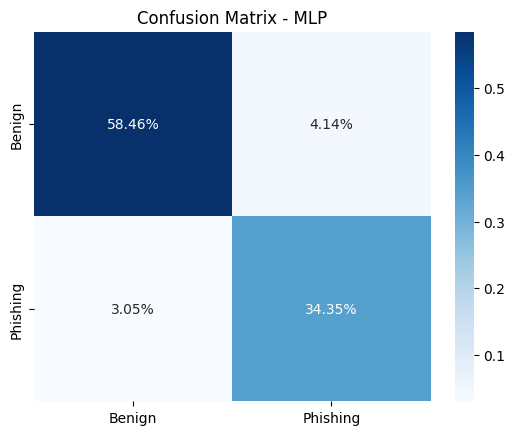

In [21]:
params = {
    # 'LR': {
    #     'C': [0.01, 0.1, 1, 10],
    #     'solver': ['lbfgs', 'liblinear','saga','sag'],
    #     'max_iter': [100, 200, 300]
    # },
    # 'KNN': {
    #     'n_neighbors': [3, 5, 7, 10],
    #     'weights': ['uniform', 'distance'],
    #     'metric': ['euclidean', 'manhattan']
    # },
    # 'RFC': {
    #     'n_estimators': [50, 100, 150, 200],
    #     'max_depth': [None, 10, 20, 30],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4]
    # },
    # 'MLP': {
    #     'hidden_layer_sizes': [(1,),(100, 100),(128,64,32), (256,128,64)],
    #     'activation': ['relu', 'tanh', 'identity', 'logistic'],
    #     'solver': ['adam', 'sgd', 'lbfgs'],
    #     'learning_rate_init': [0.001, 0.01],
    # }
}

# define the list of classifiers
clfs = [
    # best: {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
    ('LR', LogisticRegression(random_state=42,C=0.1)),
    # best: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
    ('KNN', KNeighborsClassifier(metric='euclidean',weights='distance')),
    # best: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200} 
    ('RFC', RandomForestClassifier(random_state=42,n_estimators=200,min_samples_split=10)),
    # best: {'activation': 'relu', 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.001, 'solver': 'adam'}
    ('MLP', MLPClassifier(random_state=42, learning_rate='adaptive',hidden_layer_sizes=(256,128,64), max_iter=1000))
]

print(f"Pre-Process used: {pre_processor}")

with joblib.parallel_backend('loky', n_jobs=-1):
    for label, clf in clfs:

        if label in list(params.keys()):
            grid_search = GridSearchCV(estimator= clf, param_grid=params[label], cv=3,verbose= 1)
            grid_search.fit(X_train, y_train)
            best_clf = grid_search.best_estimator_

            print(f"Best parameters for {label}: {grid_search.best_params_}")

            # Use the best model to predict and evaluate
            predictions = best_clf.predict(X_test)
        else:
            # train the model
            clf.fit(X_train, y_train)

            # generate predictions
            predictions = clf.predict(X_test)

        # we want to save the mlp one
        if label == "MLP":
            model_and_pre_processor["model"] = clf

        print(f"Classification Report for {label}:\n")
        print(classification_report(y_test, predictions,target_names=["Benign","Phishing"]))

        cm = confusion_matrix(y_test, predictions)

        sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Benign', 'Phishing'], yticklabels=['Benign', 'Phishing'])
        plt.title(f"Confusion Matrix - {label}")
        plt.show()

## Saving the model

In [14]:
SAVE_PATH = os.path.join(".","my_trained_model.joblib")
joblib.dump(model_and_pre_processor,SAVE_PATH)

['.\\my_trained_model.joblib']